**Model Selection Considerations**

| Data Assumptions | Assumptions Test |
|------|------|
|   Univariate Timeseries | N/A|
|   Normal Distribution | p-test, visual inspection of histograms, q-q plots, box plots |
|   Regular Time Series | domain knowledge/put a groupby on it|

- like most forecasting problems, the uncertainty increases greatly as you predict further into the future. It is best to keep the forecast small. 

**Use Cases**
- Good for really any type of time series data.

**Dependencies**

In [43]:
import pandas as pd
import matplotlib.pyplot as plt 

**Load Data**

In [65]:
df = pd.read_csv('data/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


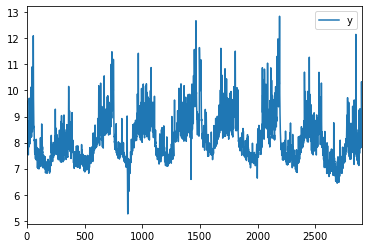

In [66]:
df.plot()

In [67]:
#split dataset into smaller dataset for training
small_df = df[:(int(len(df)*.3))]
small_df.tail()

,ds,y
866,2010-06-05,7.433075
867,2010-06-06,7.285507
868,2010-06-07,7.935587
869,2010-06-08,9.019543
870,2010-06-09,7.225481


**Data Preperation: Required Inputs and Format**
- Dataframe with one column of dependent values
- (Required) y : array-like or iterable, shape=(n_samples,)
            The time-series to which to fit the ``ARIMA`` estimator. This may
            either be a Pandas ``Series`` object (statsmodels can internally
            use the dates in the index), or a numpy array. This should be a
            one-dimensional array of floats, and should not contain any
            ``np.nan`` or ``np.inf`` values.
- Don't train on an incomplete cycle. 

In [68]:
#preprocessing (since arima takes univariate series as input)
small_df.drop('ds',axis=1,inplace=True)
print('len dataset:' + str(len(small_df)))
small_df.head()

len dataset:871


/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,y
0,9.590761
1,8.519590
2,8.183677
3,8.072467
4,7.893572


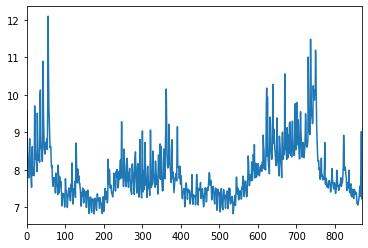

In [69]:
small_df['y'].plot()
#calculating a good length for number of outputs ~30% 
short_dfoutput_len = 0.3*(len(df))

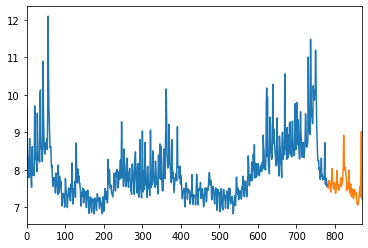

In [71]:
#divide into train and validation set
train = small_df[:int(0.9*(len(small_df)))]
valid = small_df[int(0.9*(len(small_df))):]

#plotting the data
train['y'].plot()
valid['y'].plot()

**Optional Inputs**
- exogenous : array-like, shape=[n_obs, n_vars], optional (default=None)
            An optional 2-d array of exogenous variables. If provided, these
            variables are used as additional features in the regression
            operation. This should not include a constant or trend. Note that
            if an ``ARIMA`` is fit on exogenous features, it must be provided
            exogenous features for making predictions.
- exogenous definition: An independent variable that affects a model without being affected by it, and whose qualitative characteristics and method of generation are not specified by the model builder. I.E. if you wanted to model the temperature of a soup in a pot, the preprogrammed temperature of the hot plate would be the exogenous variable. 
- Tons of optional arguments listed [here](https://github.com/alkaline-ml/pmdarima/blob/b79db3111e087e6a6a2181de1f267fcd2d953079/pmdarima/arima/auto.py#L69). However, auto-arima should be able to find all of those parameters for you, so you don't have to explicitly define them. 
- My recommendation is to just include the following as optional arguments: 
`(m=1, seasonal=True, stationary=False, trace=True, error_action='ignore', suppress_warnings=True)`

**Input Defaults**
- just a the dependent variable

**Minimal Output**
- Plain forecast without exogeneous series

In [72]:
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, stationary=False, m=4)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 4); AIC=794.742, BIC=832.037, Fit time=1.454 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 4); AIC=953.504, BIC=962.828, Fit time=0.072 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 4); AIC=934.671, BIC=953.319, Fit time=0.181 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 4); AIC=884.545, BIC=903.192, Fit time=0.315 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 4); AIC=794.261, BIC=826.894, Fit time=0.847 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 4); AIC=794.265, BIC=822.236, Fit time=0.648 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 2, 4); AIC=790.385, BIC=827.680, Fit time=1.814 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 2, 4); AIC=806.909, BIC=839.542, Fit time=1.534 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 2, 4); AIC=804.545, BIC=846.502, Fit time=1.783 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 2, 4);

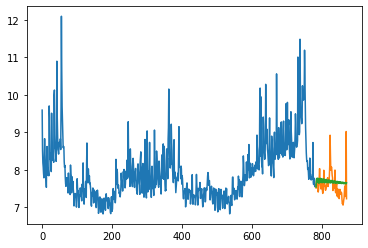

In [73]:
model.fit(train)

forecast = model.predict(n_periods=(len(valid)))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [82]:
#What a plain forecast output would look like without appending to validation set. The actual output we would get assuming evaluation would happen in a seperate image. 
forecast2 = model.predict(n_periods=(len(valid)))
forecast2 = pd.DataFrame(forecast2, columns=['Prediction'])
forecast2.head()

,Prediction
0,7.535587
1,7.725336
2,7.768399
3,7.674405
4,7.710486


**Additional Tuning Options and Considerations**

I haven't added anything about [gaps in data](https://facebook.github.io/prophet/docs/non-daily_data.html#data-with-regular-gaps), because I'm not sure what the UX should/could look like. 

[Additional Reggressors](https://towardsdatascience.com/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda): For [example](https://github.com/abaranovskis-redsamurai/automation-repo/blob/master/forecast/bikesharing_forecast_prophet_regressor2.ipynb), adding temperature and weather condition as a regressor to evaluate bike rentals. Future values of regressors have to be known in order to incorporate them with Prophet. You could perhaps use Prophet to make forecasts on regressors and then add those predictions/regressors to your main forecast. *Question* Could that approach cause overfitting? 
- If we were to include the option to include multiple regressors I imagine that the UX would be something like:
    - Specify your forecast period. 
    - Specify your `y` or main forecast with a Flux Query.
    - Specify input parameters for main forecast. 
    - Specify each regressor with a unique flux query. The simplest Prophet model is used 

    `m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=365)
    future.tail()
    forecast = m.predict(future)forecast[['ds','yhat']].tail()` 

    to forecast each regressor.
    - The regressor is added with:
    `future['temp'] = future['ds'].apply(weather_temp)`
    - Any added seasonalities or extra regressors will by default use whatever seasonality_mode is set to, but can be overriden by specifying `mode='additive'` or `mode='multiplicative'` as an argument when adding the seasonality or regressor.
    
    `m = Prophet(seasonality_mode='multiplicative')
    m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
    m.add_regressor('regressor', mode='additive')`
 - In other words, the functions that add the regressor forecasts are created automatically. This code would be autogenerated (please see [example](https://github.com/abaranovskis-redsamurai/automation-repo/blob/master/forecast/bikesharing_forecast_prophet_regressor2.ipynb) for context): 
 

In [30]:
 def weather_temp(ds):
    date = (pd.to_datetime(ds)).date()
    if d_df[date:].empty:
        return future_temp_df[date:]['future_temp'].values[0]
    else:
        return (d_df[date:]['temp']).values[0]
    return 0

def weather_condition(ds):
    date = (pd.to_datetime(ds)).date()
    if d_df[date:].empty:
        return future_temp_df[date:]['future_weathersit'].values[0]
    else:
        return (d_df[date:]['weathersit']).values[0]
    return 0

m = Prophet()
m.add_regressor('temp')
m.add_regressor('weathersit')
m.fit(d_df)

future = m.make_future_dataframe(periods=10)
future['temp'] = future['ds'].apply(weather_temp)
future['weathersit'] = future['ds'].apply(weather_condition)

**Example of Autogenerating Regression Code**

Predicting the Temperature using Humidity as a regressor 

In [156]:
df= pd.read_csv('data/weather_day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [157]:
#data cleanup to get data in the correct form
weather = df[['dteday', 'temp', 'hum']].copy()
weather['dteday'] = pd.to_datetime(weather['dteday'])
weather.head()

,dteday,temp,hum
0,2011-01-01,0.344167,0.805833
1,2011-01-02,0.363478,0.696087
2,2011-01-03,0.196364,0.437273
3,2011-01-04,0.200000,0.590435
4,2011-01-05,0.226957,0.436957


Assuming user can write two queries--one to specify the data they wish to forecast and two the regressor. Splitting up raw data into these two time time series

In [158]:
query_one = weather[['dteday', 'temp']].copy().rename(columns={"dteday": "ds", "temp": "y"})
query_one.tail()

,ds,y
726,2012-12-27,0.254167
727,2012-12-28,0.253333
728,2012-12-29,0.253333
729,2012-12-30,0.255833
730,2012-12-31,0.215833


In [159]:
query_two_regressor = weather[['dteday', 'hum']].copy().rename(columns={"dteday": "ds", "hum": "y"})
query_two_regressor.tail()

,ds,y
726,2012-12-27,0.652917
727,2012-12-28,0.590000
728,2012-12-29,0.752917
729,2012-12-30,0.483333
730,2012-12-31,0.577500


In [243]:
#Use Prophet to forecast the regressor values
m = Prophet()
m.fit(query_two_regressor)
future_regressor = m.make_future_dataframe(periods=10)
future.tail()
forecast_regressor = m.predict(future_regressor)
forecast_regressor[['ds','yhat']].tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
736,2013-01-06,0.514720
737,2013-01-07,0.523615
738,2013-01-08,0.527004
739,2013-01-09,0.531515
740,2013-01-10,0.497589


In [246]:
#merge together the data you wish to forecast (query_one) and the forecasted regressor values
together = pd.merge(query_one, forecast_regressor[['ds','yhat']], on=['ds'], how="right")
together = together.rename(columns={"yhat": "hum"})
together.tail(20)


,ds,y,hum
721,2012-12-22,0.265833,0.616434
722,2012-12-23,0.245833,0.615394
723,2012-12-24,0.231304,0.615913
724,2012-12-25,0.291304,0.609751
725,2012-12-26,0.243333,0.603693
726,2012-12-27,0.254167,0.558362
727,2012-12-28,0.253333,0.553422
728,2012-12-29,0.253333,0.550687
729,2012-12-30,0.255833,0.550564
730,2012-12-31,0.215833,0.552885


In [249]:
#Make forecast and include the regressor
m = Prophet()
m.add_regressor('hum')
m.fit(together)
forecast = m.predict(together)
forecast[['ds','yhat']].tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
736,2013-01-06,0.234212
737,2013-01-07,0.238787
738,2013-01-08,0.242442
739,2013-01-09,0.238008
740,2013-01-10,0.233313


**Stopped working on this idea because I'm not sure if it's really kosher to use prophet to forecast the regressor values to then use to help create the forecast** I'm not sure where/who I should ask about this. 

**Method Evaluation**